In [73]:
%reset -f
import sys
print("Python version")
print(sys.version)

Python version
3.7.9 (tags/v3.7.9:13c94747c7, Aug 17 2020, 18:58:18) [MSC v.1900 64 bit (AMD64)]


In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')

In [75]:
#Coingecko api
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()

In [76]:
import time
import datetime

def edit_prices_dict(d): 
    df=pd.DataFrame(d)
    #Saving dates
    dates=df['prices'].map(lambda x: x[0])  
    #Filtering the values without dates
    df=df.applymap(lambda x: x[1])
    df['dates']=dates 
    df["dates"] = pd.to_datetime(df['dates'], unit='ms')
    df.index = df["dates"]
    #df=df[['prices','total_volumes']]
    return df

In [77]:
#dd/mm/yyyy
from_date = "01/01/2021"
to_date = "21/12/2021"
from_unix = time.mktime(datetime.datetime.strptime(from_date, "%d/%m/%Y").timetuple())
to_unix = time.mktime(datetime.datetime.strptime(to_date, "%d/%m/%Y").timetuple())

token = "bitcoin"; vs_currency = "usd"

response=cg.get_coin_market_chart_range_by_id(id = token, vs_currency = vs_currency, from_timestamp = from_unix, to_timestamp = to_unix)

In [78]:
df = edit_prices_dict(response)
print(df.shape)
df.tail()

(342, 4)


,prices,market_caps,total_volumes,dates
dates,,,,
2021-12-04,53785.967172,1.016041e+12,3.952711e+10,2021-12-04
2021-12-05,49161.990710,9.300975e+11,5.594141e+10,2021-12-05
2021-12-06,49268.469891,9.320151e+11,3.282657e+10,2021-12-06
2021-12-07,50461.576837,9.533967e+11,3.612602e+10,2021-12-07
2021-12-08,50647.663406,9.569613e+11,3.008331e+10,2021-12-08


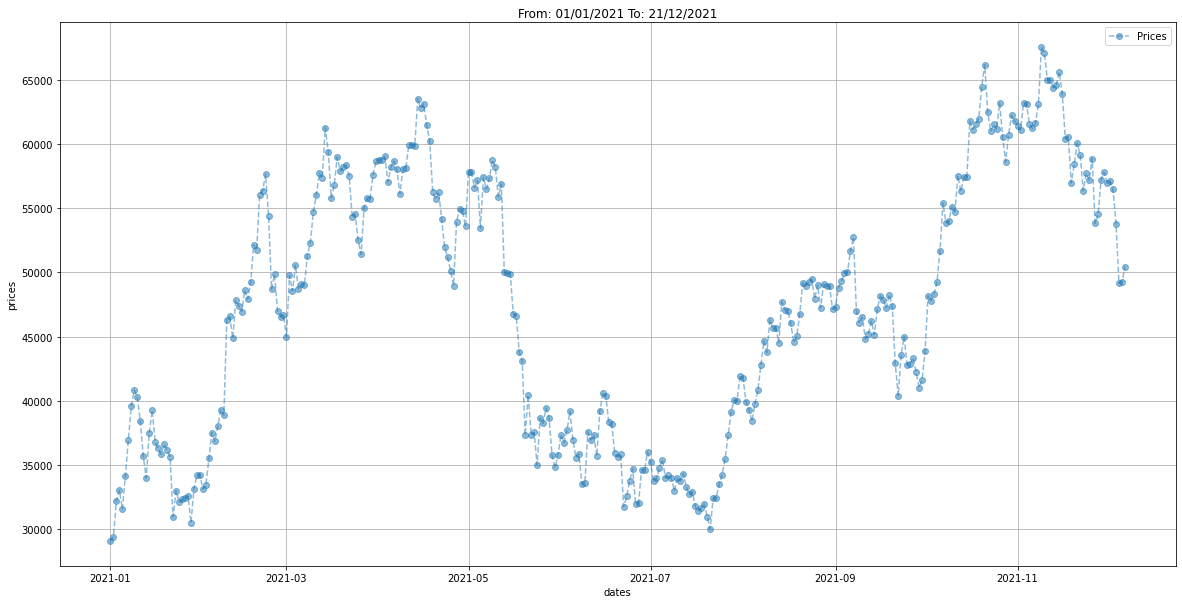

In [54]:
fig=plt.figure(figsize=(20, 10))
plt.plot(df['prices'], '--o', label = 'Prices', alpha = 0.5)
plt.title('From: ' + from_date + ' To: ' + to_date) 
plt.xlabel('dates')
plt.ylabel('prices')
plt.legend()
plt.grid(True)

In [55]:
# Esto hay que hacerlo pues es con la info de hoy predecir mañana
lag_days = 1
df["y"] = df["prices"].shift(-1 * lag_days)
df.tail(5)

,prices,total_volumes,y
dates,,,
2021-12-03,56508.268054,3.629634e+10,53785.967172
2021-12-04,53785.967172,3.952711e+10,49161.990710
2021-12-05,49161.990710,5.594141e+10,49268.469891
2021-12-06,49268.469891,3.282657e+10,50461.576837
2021-12-07,50461.576837,3.612602e+10,NaN


#### Se calculan indicadores para cada día

In [56]:
#https://towardsdatascience.com/building-a-comprehensive-set-of-technical-indicators-in-python-for-quantitative-trading-8d98751b5fb
# MovingAverage
values_ma = [5,15,30]

for i in values_ma:
    df["ma_close_" + str(i)] = df["prices"].rolling(window=i).mean()

# ExponentialMovingWindow
values_ema = [5,15,30]

for i in values_ema:
    df["ema_" + str(i)] = df["prices"].ewm(span = i, adjust = False).mean()
    
# RSI https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
values_rsi = [7,14,21]
close = df['prices']

# Get the difference in price from previous step
delta = close.diff()

# Make the positive gains (up) and negative gains (down) Series
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0

for i in values_rsi:
    # Calculate the EWMA
    #roll_up1 = up.ewm(span=i).mean()
    #roll_down1 = down.abs().ewm(span=i).mean()

    ## Calculate the RSI based on EWMA
    #RS1 = roll_up1 / roll_down1
    #RSI1 = 100.0 - (100.0 / (1.0 + RS1))

    # Calculate the SMA
    roll_up2 = up.rolling(i).mean()
    roll_down2 = down.abs().rolling(i).mean()

    # Calculate the RSI based on SMA
    RS2 = roll_up2 / roll_down2
    RSI2 = 100.0 - (100.0 / (1.0 + RS2))
    
    #df["rsi_ewma_" + str(i)] = RSI1.values
    df["rsi_sma_" + str(i)]  = RSI2.values
    
# BollingerBand
values_bollinger = [5,10,20]
for i in values_bollinger:
    df['bollinger_upper_' + str(i)] = df['prices'].rolling(window=i).mean() + (df['prices'].rolling(window=i).std()  * 2)
    df['bollinger_lower_' + str(i)] = df['prices'].rolling(window=i).mean() - (df['prices'].rolling(window=i).std()  * 2)

In [57]:
df.sample()

,prices,total_volumes,y,ma_close_5,ma_close_15,ma_close_30,ema_5,ema_15,ema_30,rsi_sma_7,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20
dates,,,,,,,,,,,,,,,,,,
2021-11-04,63130.942352,3.656144e+10,61601.743572,62161.821596,61925.763221,59788.511033,62361.279592,61357.494026,58933.816517,81.865213,42.169966,59.42221,64106.099944,60217.543248,64532.019366,58734.633849,65163.067847,58834.982515


In [58]:
minus = 15 # Es el lag del pasado cuanto pillamos

In [59]:
all_columns = list(df.columns)
keep_columns = [item for item in all_columns if item not in "y"]
print(keep_columns)

['prices', 'total_volumes', 'ma_close_5', 'ma_close_15', 'ma_close_30', 'ema_5', 'ema_15', 'ema_30', 'rsi_sma_7', 'rsi_sma_14', 'rsi_sma_21', 'bollinger_upper_5', 'bollinger_lower_5', 'bollinger_upper_10', 'bollinger_lower_10', 'bollinger_upper_20', 'bollinger_lower_20']


In [60]:
list_shift = list(range(1, minus))

for i in list_shift:
    for j in keep_columns:
        df[str(j) + "minus" + str(i)] = df[str(j)].shift(i)

In [61]:
print("Shape: " + str(df.shape))
df.dropna(inplace = True)
print("Shape: " + str(df.shape))

Shape: (341, 256)
Shape: (297, 256)


In [62]:
df.tail(1)

,prices,total_volumes,y,ma_close_5,ma_close_15,ma_close_30,ema_5,ema_15,ema_30,rsi_sma_7,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20,pricesminus1,total_volumesminus1,ma_close_5minus1,ma_close_15minus1,ma_close_30minus1,ema_5minus1,ema_15minus1,ema_30minus1,rsi_sma_7minus1,rsi_sma_14minus1,rsi_sma_21minus1,bollinger_upper_5minus1,bollinger_lower_5minus1,bollinger_upper_10minus1,bollinger_lower_10minus1,bollinger_upper_20minus1,bollinger_lower_20minus1,pricesminus2,total_volumesminus2,ma_close_5minus2,ma_close_15minus2,ma_close_30minus2,ema_5minus2,ema_15minus2,ema_30minus2,rsi_sma_7minus2,rsi_sma_14minus2,rsi_sma_21minus2,bollinger_upper_5minus2,bollinger_lower_5minus2,bollinger_upper_10minus2,bollinger_lower_10minus2,bollinger_upper_20minus2,bollinger_lower_20minus2,pricesminus3,total_volumesminus3,ma_close_5minus3,ma_close_15minus3,ma_close_30minus3,ema_5minus3,ema_15minus3,ema_30minus3,rsi_sma_7minus3,rsi_sma_14minus3,rsi_sma_21minus3,bollinger_upper_5minus3,bollinger_lower_5minus3,bollinger_upper_10minus3,bollinger_lower_10minus3,bollinger_upper_20minus3,bollinger_lower_20minus3,pricesminus4,total_volumesminus4,ma_close_5minus4,ma_close_15minus4,ma_close_30minus4,ema_5minus4,ema_15minus4,ema_30minus4,rsi_sma_7minus4,rsi_sma_14minus4,rsi_sma_21minus4,bollinger_upper_5minus4,bollinger_lower_5minus4,bollinger_upper_10minus4,bollinger_lower_10minus4,bollinger_upper_20minus4,bollinger_lower_20minus4,pricesminus5,total_volumesminus5,ma_close_5minus5,ma_close_15minus5,ma_close_30minus5,ema_5minus5,ema_15minus5,ema_30minus5,rsi_sma_7minus5,rsi_sma_14minus5,rsi_sma_21minus5,bollinger_upper_5minus5,bollinger_lower_5minus5,bollinger_upper_10minus5,bollinger_lower_10minus5,bollinger_upper_20minus5,bollinger_lower_20minus5,pricesminus6,total_volumesminus6,ma_close_5minus6,ma_close_15minus6,ma_close_30minus6,ema_5minus6,ema_15minus6,ema_30minus6,rsi_sma_7minus6,rsi_sma_14minus6,rsi_sma_21minus6,bollinger_upper_5minus6,bollinger_lower_5minus6,bollinger_upper_10minus6,bollinger_lower_10minus6,bollinger_upper_20minus6,bollinger_lower_20minus6,pricesminus7,total_volumesminus7,ma_close_5minus7,ma_close_15minus7,ma_close_30minus7,ema_5minus7,ema_15minus7,ema_30minus7,rsi_sma_7minus7,rsi_sma_14minus7,rsi_sma_21minus7,bollinger_upper_5minus7,bollinger_lower_5minus7,bollinger_upper_10minus7,bollinger_lower_10minus7,bollinger_upper_20minus7,bollinger_lower_20minus7,pricesminus8,total_volumesminus8,ma_close_5minus8,ma_close_15minus8,ma_close_30minus8,ema_5minus8,ema_15minus8,ema_30minus8,rsi_sma_7minus8,rsi_sma_14minus8,rsi_sma_21minus8,bollinger_upper_5minus8,bollinger_lower_5minus8,bollinger_upper_10minus8,bollinger_lower_10minus8,bollinger_upper_20minus8,bollinger_lower_20minus8,pricesminus9,total_volumesminus9,ma_close_5minus9,ma_close_15minus9,ma_close_30minus9,ema_5minus9,ema_15minus9,ema_30minus9,rsi_sma_7minus9,rsi_sma_14minus9,rsi_sma_21minus9,bollinger_upper_5minus9,bollinger_lower_5minus9,bollinger_upper_10minus9,bollinger_lower_10minus9,bollinger_upper_20minus9,bollinger_lower_20minus9,pricesminus10,total_volumesminus10,ma_close_5minus10,ma_close_15minus10,ma_close_30minus10,ema_5minus10,ema_15minus10,ema_30minus10,rsi_sma_7minus10,rsi_sma_14minus10,rsi_sma_21minus10,bollinger_upper_5minus10,bollinger_lower_5minus10,bollinger_upper_10minus10,bollinger_lower_10minus10,bollinger_upper_20minus10,bollinger_lower_20minus10,pricesminus11,total_volumesminus11,ma_close_5minus11,ma_close_15minus11,ma_close_30minus11,ema_5minus11,ema_15minus11,ema_30minus11,rsi_sma_7minus11,rsi_sma_14minus11,rsi_sma_21minus11,bollinger_upper_5minus11,bollinger_lower_5minus11,bollinger_upper_10minus11,bollinger_lower_10minus11,bollinger_upper_20minus11,bollinger_lower_20minus11,pricesminus12,total_volumesminus12,ma_close_5minus12,ma_close_15minus12,ma_close_30minus12,ema_5minus12,ema_15minus12,ema_30minus12,rsi_sma_7minus12,rsi_sma_14minus12,rsi_sma_21minus12,bollinger_upper_

In [63]:
df.dtypes.value_counts()

float64    256
dtype: int64

In [64]:
# Importing module and initializing setup
from pycaret.regression import *

def pipeline(df):
    modelo = setup(data = df,
                   target = 'y', feature_interaction = False,
                   remove_outliers = True,
                   normalize = True, normalize_method = "zscore",
                   silent = True, verbose = False);

In [65]:
print("Dimensiones :" , df.shape)

Dimensiones : (297, 256)


In [66]:
past_t = 250 # Es hiperparametro del modelo

In [67]:
y_real = pd.DataFrame(list(df["y"].iloc[past_t:len(df["y"])]), columns = ["y_real"], index = df["y"].iloc[past_t:len(df["y"])].index)
y_pred = pd.DataFrame([999] * (len(df["y"])-past_t), columns = ["y_pred"], index = df["y"].iloc[past_t:len(df["y"])].index, dtype = 'int')

comparacion = pd.concat([y_real, y_pred], axis =1).copy()
comparacion.dtypes

y_real    float64
y_pred      int32
dtype: object

In [68]:
tope = len(df)-past_t

# MAE, MSE, RMSE, R2, RMSLE and MAPE
metrica = "RMSLE"
print("Tope: " + str(tope))

Tope: 47


In [69]:
for i in range(0, tope):
    # Train
    train = df.iloc[i:i+past_t]
    
    # Test
    test = df.iloc[i+past_t:i+past_t+1]
    
    # Crear pipeline
    pipeline(train)
    
    # Modelo
    modelo = compare_models(sort = metrica, exclude = ["lar"] ,verbose=False)
    
    modelo = tune_model(modelo, search_algorithm = "tpe", search_library = "optuna", optimize = metrica, n_iter = 10,
                    tuner_verbose = False, choose_better = True, verbose = False );
    
    final_modelo = finalize_model(modelo)
    prediccion = predict_model(final_modelo, data = test)
    
    comparacion.at[ df.iloc[past_t:len(df["y"])].index[i], "y_pred" ]  = prediccion["Label"]
    comparacion.at[ df.iloc[past_t:len(df["y"])].index[i], "y_real" ]  = prediccion["y"]
    
    print("Iteration: " + str(i+1) + "/" + str(tope) + " | Date " + str(test.index[0]) + " | RealValue " + str(test.y[0]) + " | Prediccion " + str(prediccion.Label[0]) , end = "\r")

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already speci

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already speci

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already speci

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already speci

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already speci

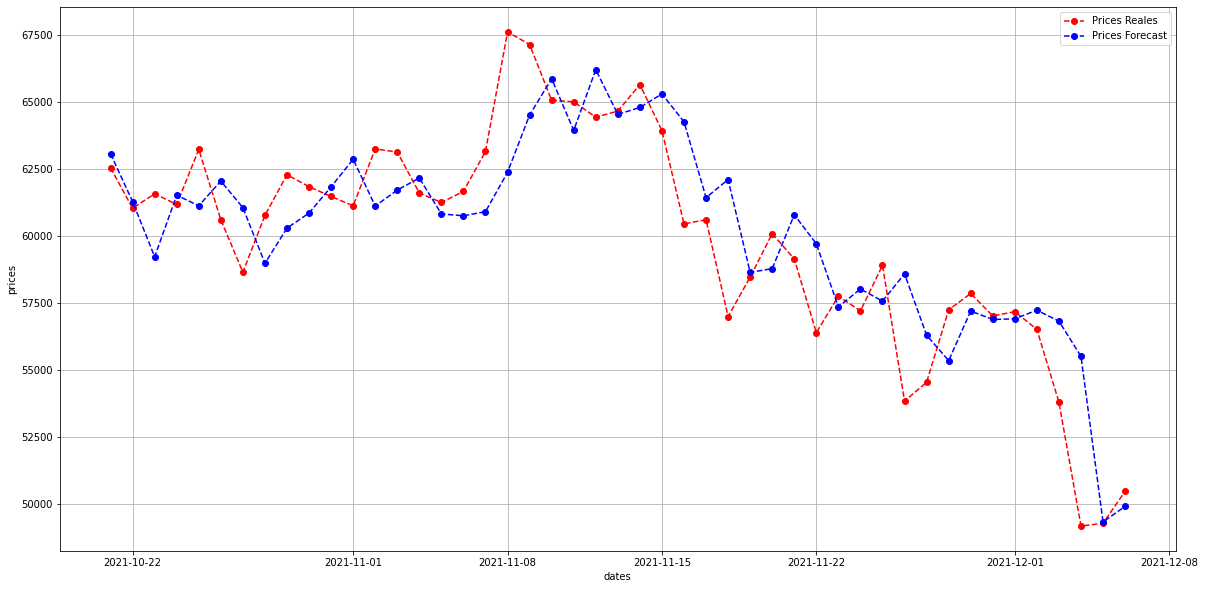

In [70]:
fig=plt.figure(figsize=(20, 10))
plt.plot(comparacion['y_real'], '--bo', label = 'Prices Reales', color = "r")
plt.plot(comparacion["y_pred"], '--bo', label = 'Prices Forecast', color = "b")
plt.xlabel('dates')
plt.ylabel('prices')
plt.legend()
plt.grid(True)
plt.savefig('imagen.png', dpi = 200)
plt.show()

### Telegram

In [71]:
import telepot

bot_token = '1653124784:AAFpL0qlC_ybadcbFX6jKagauRFpiFpSf1E'
chatID = '-1001701018194'

bot = telepot.Bot(bot_token)

In [72]:
#bot.sendMessage(bot_chatID, "HALA")
bot.sendPhoto(chatID, photo=open('imagen.png', 'rb'))

{'message_id': 13,
 'from': {'id': 1653124784,
  'is_bot': True,
  'first_name': 'JARVIS',
  'username': 'JARVIS_Walkn_bot'},
 'chat': {'id': -1001701018194,
  'title': 'MoneyIsJustANumber',
  'type': 'supergroup'},
 'date': 1638934774,
 'photo': [{'file_id': 'AgACAgQAAx0EZWN6UgADDWGwKPXJcQmARO5wAsXcUSidEujbAAKWuDEbi6yBUZzC3GoV63D2AQADAgADcwADIwQ',
   'file_unique_id': 'AQADlrgxG4usgVF4',
   'file_size': 568,
   'width': 90,
   'height': 45},
  {'file_id': 'AgACAgQAAx0EZWN6UgADDWGwKPXJcQmARO5wAsXcUSidEujbAAKWuDEbi6yBUZzC3GoV63D2AQADAgADbQADIwQ',
   'file_unique_id': 'AQADlrgxG4usgVFy',
   'file_size': 7674,
   'width': 320,
   'height': 160},
  {'file_id': 'AgACAgQAAx0EZWN6UgADDWGwKPXJcQmARO5wAsXcUSidEujbAAKWuDEbi6yBUZzC3GoV63D2AQADAgADeAADIwQ',
   'file_unique_id': 'AQADlrgxG4usgVF9',
   'file_size': 31348,
   'width': 800,
   'height': 400},
  {'file_id': 'AgACAgQAAx0EZWN6UgADDWGwKPXJcQmARO5wAsXcUSidEujbAAKWuDEbi6yBUZzC3GoV63D2AQADAgADeQADIwQ',
   'file_unique_id': 'AQADlrgxG4usgVF-'